## Predicting stock prices using past trends

In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from pmdarima.arima import AutoARIMA

import logging
import warnings
from fbprophet import Prophet
logging.getLogger('py4j').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.simplefilter(action='ignore', category=FutureWarning)

### Data Preprocessing

In [ ]:
spark = SparkSession.builder.getOrCreate()

# Making connection with ATLAS MongoDB
database = '####'
user_name = '####'
password = '####'
address = '#######'
collection = 'ts_da'
connection_string = f"mongodb+srv://{user_name}:{password}@{address}/{database}.{collection}"

# Loading the data and converting some columns data types
df = spark.read.format("mongo").option("uri",connection_string).load()
df = df.withColumn("close",col("close").cast("float"))
df = df.withColumn("open",col("open").cast("float"))
df = df.withColumn("low",col("low").cast("float"))
df = df.withColumn("high",col("high").cast("float"))
# Converting Date column in to date fromat
df = df.withColumn("date", to_date("date", "yyyy-MM-dd"))

# Taking around last 1 year data to fit the model and make predictions
df = df.select('date', 'symbol', 'open', 'close', 'low', 'high') \
      .filter((col("date") >= "2022-03-01")) \
      .orderBy(asc("date"))

df.show(5)

+----------+------+------+----------+------+------+
|      date|symbol|  open|     close|   low|  high|
+----------+------+------+----------+------+------+
|2022-03-01|   XOM| 78.77| 76.429085| 78.33| 80.65|
|2022-03-01|   PGR|105.23|102.903175|103.19|105.87|
|2022-03-01|    VZ|  53.5| 50.621178| 53.26| 54.19|
|2022-03-01|   AXP|194.67| 175.61913|176.77|194.77|
|2022-03-01|  MSFT| 296.4| 292.04614|292.15|299.97|
+----------+------+------+----------+------+------+
only showing top 5 rows



### ARIMA Model
- Training only with close price

Symbol: AAPL, MAE: 2.2537814522139117, MSE: 6.123854483972711


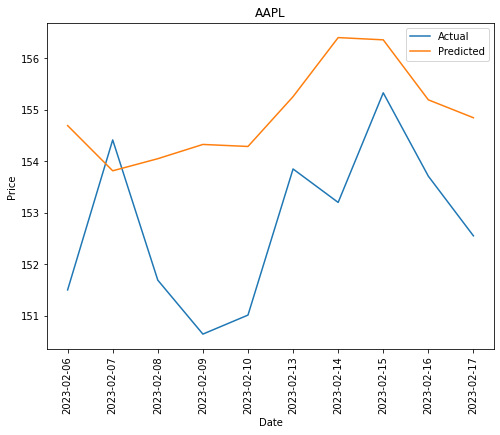

In [ ]:
symbols = ["AAPL"] # can add more symbols if needed
 
for symbol in symbols:
    # Filtering data based on symbol
    symbol_data = df.filter(col("symbol") == symbol)
    
    # Creating a VectorAssembler to combine features
    assembler = VectorAssembler(inputCols=["close"], outputCol="features")
    
    # Transforming the data
    symbol_data = assembler.transform(symbol_data)
    
    # Spliting the data into training and testing sets
    train_data = symbol_data.filter(col("date") <= "2023-02-05") 
    test_data = symbol_data.filter(col("date") > "2023-02-05").limit(10)
    
    # Fiting the AutoARIMA model on the training data
#     model = AutoARIMA(trace=False, suppress_warnings=True, seasonal=True, d=1, max_p=5, max_q=5, trend='ct')
    model = AutoARIMA(trace=False, suppress_warnings=True, seasonal=True, 
                  d=1, max_p=2, max_q=2, trend='ct', D=1, max_P=2, max_Q=2, m=12)
    model.fit(train_data.select("close").toPandas())
    
    # Making predictions on the test data
    predictions = model.predict(n_periods=10)
    
    # Evaluating tmodel using mean absolute error and mean squared error
    y_true = test_data.select("close").toPandas()
    y_pred = predictions.to_numpy().reshape(-1, 1)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    print(f"Symbol: {symbol}, MAE: {mae}, MSE: {mse}")
    
    # Plotting actual and predicted stock prices
    dates = [str(row.date) for row in test_data.select("date").collect()]
    actual_prices = [row.close for row in test_data.select("close").collect()]
    predicted_prices = predictions.tolist()
    
    plt.figure(figsize=(8, 6))
    plt.plot(dates, actual_prices, label="Actual")
    plt.plot(dates, predicted_prices, label="Predicted")
    plt.title(symbol)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.xticks(dates, rotation=90)
    plt.legend()
    plt.show()

#### Training with all the prices("open", "high", "low", "close") and comparing prediction with all

Symbol: AAPL, close : MAE : 2.6246530150766203, MSE: 11.165710045792569
Symbol: AAPL, open : MAE : 3.5230104328680456, MSE: 17.99343485258813
Symbol: AAPL, low : MAE : 4.305462036072714, MSE: 23.708999653760795
Symbol: AAPL, high : MAE : 1.8808193100665676, MSE: 7.990115104788575


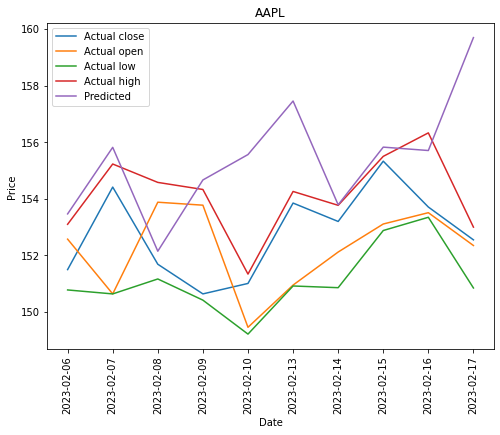

In [ ]:
symbols = ["AAPL"]
# symbols = ["WMT"]

for symbol in symbols:
    # Filtering data based on symbol
    symbol_data = df.filter(col("symbol") == symbol)
    
    # Creating a VectorAssembler to combine features
#     assembler = VectorAssembler(inputCols=["close"], outputCol="features")
    assembler = VectorAssembler(inputCols=["open", "high", "low", "close"], outputCol="features")
    
    # Transforming the data
    symbol_data = assembler.transform(symbol_data)
    
    # Spliting the data into training and testing sets
    train_data = symbol_data.filter(col("date") <= "2023-02-05") 
    test_data = symbol_data.filter(col("date") > "2023-02-05").limit(10)
    
    # Fiting the AutoARIMA model on the training data
    model = AutoARIMA(trace=False, suppress_warnings=True, seasonal=True, 
                  d=1, max_p=2, max_q=2, trend='ct', D=1, max_P=2, max_Q=2, m=12)
    features = train_data.select("features").rdd.map(lambda x: x[0]).collect()
    features_array = np.array(features)
    model.fit(features_array.reshape(-1))
#     model.fit(features.ravel().tolist())

    
    # Making predictions on the test data
    predictions = model.predict(n_periods=10)
    
    # Evaluating model using mean absolute error and mean squared error
    metrics = ["close", "open", "low", "high"]
    plt.figure(figsize=(8, 6))
    for metric in metrics:
        y_true = test_data.select(metric).toPandas().values.ravel()
        y_pred = predictions.reshape(-1, 1)
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        print(f"Symbol: {symbol}, {metric} : MAE : {mae}, MSE: {mse}")
        
        # Plotting actual and predicted stock prices
        dates = [str(row.date) for row in test_data.select("date").collect()]
        actual_prices = [row[metric] for row in test_data.select(metric).collect()]
        predicted_prices = predictions.tolist()
        
        plt.plot(dates, actual_prices, label=f"Actual {metric}")
    plt.plot(dates, predicted_prices, label=f"Predicted")
    
    plt.title(symbol)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.xticks(dates, rotation=90)
    plt.legend()
    plt.show()


#### Comparing with only the close price

Symbol: AAPL, Close : MAE : 2.6246530150766203, MSE: 11.165710045792569
Symbol: WMT, Close : MAE : 3.019662390501935, MSE: 13.101396119160928


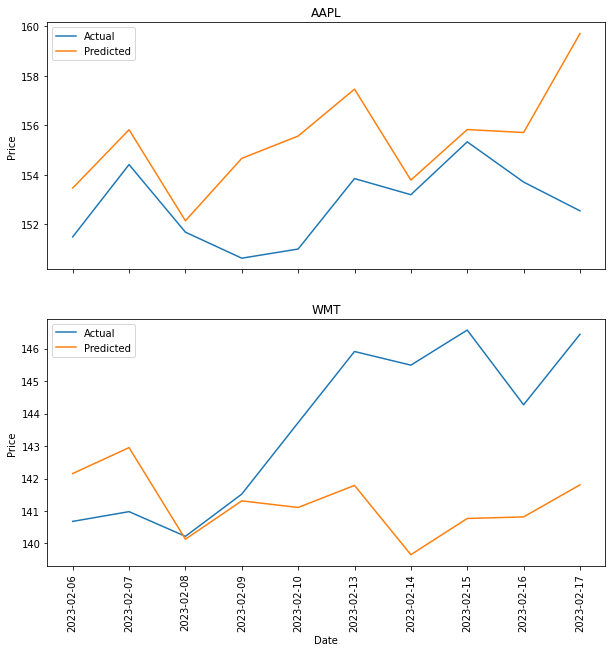

In [ ]:
symbols = ["AAPL", "WMT"]

fig, axs = plt.subplots(len(symbols), 1, figsize=(10, 5*len(symbols)), sharex=True)

for i, symbol in enumerate(symbols):
    # Filtering data based on symbol
    symbol_data = df.filter(col("symbol") == symbol)
    
    # Creating a VectorAssembler to combine features
    assembler = VectorAssembler(inputCols=["open", "high", "low", "close"], outputCol="features")
    
    # Transforming the data
    symbol_data = assembler.transform(symbol_data)
    
    # Splitting the data into training and testing sets
    train_data = symbol_data.filter(col("date") <= "2023-02-05") 
    test_data = symbol_data.filter(col("date") > "2023-02-05").limit(10)
    
    # Fitting the AutoARIMA model on the training data
    model = AutoARIMA(trace=False, suppress_warnings=True, seasonal=True, 
                  d=1, max_p=2, max_q=2, trend='ct', D=1, max_P=2, max_Q=2, m=12)
    features = train_data.select("features").rdd.map(lambda x: x[0]).collect()
    features_array = np.array(features)
    model.fit(features_array.reshape(-1))
    
    # Making predictions on the test data
    predictions = model.predict(n_periods=10)
    
    # Evaluating the model using mean absolute error and mean squared error
    y_true = test_data.select("close").toPandas().values.ravel()
    y_pred = predictions.reshape(-1, 1)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    print(f"Symbol: {symbol}, Close : MAE : {mae}, MSE: {mse}")
    
    # Plotting actual and predicted stock prices in the current subplot
    dates = [str(row.date) for row in test_data.select("date").collect()]
    actual_prices = [row.close for row in test_data.select("close").collect()]
    predicted_prices = predictions.tolist()
    
    axs[i].plot(dates, actual_prices, label="Actual")
    axs[i].plot(dates, predicted_prices, label="Predicted")
    axs[i].set_title(symbol)
    axs[i].set_ylabel("Price")
    axs[i].legend()

plt.xlabel("Date")
plt.xticks(dates, rotation=90)
plt.show()

### Prophet Model

Symbol: AAPL, MAE: 19.900050107476545, MSE: 400.04728252764863


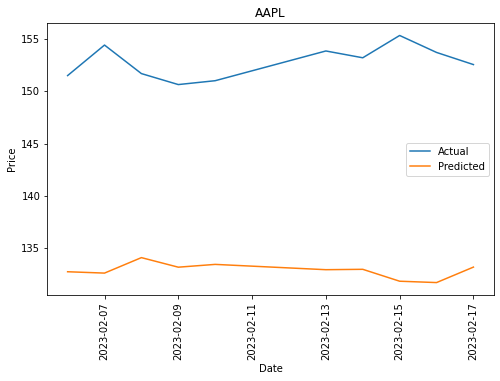

In [ ]:
# symbols = ["WMT"]
symbols = ["AAPL"]

for symbol in symbols:
    # Filtering data based on symbol
    symbol_data = df.filter(col("symbol") == symbol)
    
    # Renaming the columns to "ds" and "y" to run Prophet
    symbol_data = symbol_data.select(col("date").alias("ds"), col("close").alias("y"))
    
    # Spliting the data into training and testing sets
    train_data = symbol_data.filter(col("ds") <= "2023-02-05") 
    test_data = symbol_data.filter(col("ds") > "2023-02-05").limit(10)
    
    # Creating a Prophet model
    model = Prophet(seasonality_mode='additive', daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)#, growth='linear')
#     model = Prophet(seasonality_mode='additive', daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False,
#                     changepoint_prior_scale = 0.01, changepoint_range = 0.1, seasonality_prior_scale = 0.01)

    
    # Fitting the model to the training data
    model.fit(train_data.toPandas())
    
    # Making predictions on the test data
    future = model.make_future_dataframe(periods=10)
    predictions = model.predict(future)["yhat"].tail(10)
    
    # Evaluating model using mean absolute error and mean squared error
    y_true = test_data.select("y").toPandas()
    y_pred = predictions.to_numpy().reshape(-1, 1)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    print(f"Symbol: {symbol}, MAE: {mae}, MSE: {mse}")
    
    dates = pd.to_datetime([str(row.ds) for row in test_data.select("ds").collect()])
    
    # Plotting actual and predicted stock prices
    actual_prices = [row.y for row in test_data.select("y").collect()]
    predicted_prices = predictions.tolist()
    
    plt.figure(figsize=(8, 5))
    plt.plot(dates, actual_prices, label="Actual")
    plt.plot(dates, predicted_prices, label="Predicted")
    plt.title(symbol)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

-As per the evaluation metrics MAE and MSE it is evident Auto ARIMA models are giving better predictions as compared to Prophet models. It is very difficult to predict stock data based only on the historic data because the stock market is influenced by a lot of things like market sentiments, and economic indicators such as GDP, inflation rates, interest rates, and employment rates. That's why we can try to include some more indicators and build some models out of them.

In [ ]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.shuffle.partitions",1)



In [ ]:
@udf
def get_sentiment(text):
    finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
    tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

    nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)
    results = nlp(text.split('.'))
#     for r in results
    df_res = pd.DataFrame(results)
    sents = df_res[df_res['label']!='Neutral'].groupby(by='label', as_index=False).count().sort_values(by='score', ascending=False)
    score = 0
    for i,v in sents.iterrows():
        if 'Positive' in v['label']:
            score+=v['score']
        elif 'Negative' in v['label']:
            score-=v['score']
#     pos = list(sents[sents['label']=='Positive'].score)[0]
#     neg = list(sents[sents['label']=='Negative'].score)[0]
#     neg = list(sents[sents['label']=='Neutral'].score)[0]
    return score

@udf('int')
def convert(close_change):
    if close_change>=0:
        return 0
    else:
        return 1

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

In [ ]:
collection_name = "nyt_news"
connection_string = f"mongodb+srv://{mongo_username}:{mongo_password}@{mongo_ip_address}/{database_name}.{collection_name}"

df = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri",connection_string).load()

df = df.filter(df.ticker=='AAPL')
# df_sentiment = df.withColumn("sentiment_head", get_sentiment(df.headline))
df_sentiment = df.withColumn("sentiment_para", get_sentiment(df.lead_paragraph))
# df_sentiment = df_sentiment.withColumn("sentiment_score1", df_sentiment["sentiment_head"].cast(IntegerType())).drop("sentiment_head")
df_sentiment = df_sentiment.withColumn("sentiment_score2", df_sentiment["sentiment_para"].cast(IntegerType())).drop("sentiment_para")
# df_sents_grp = df_sentiment.select(first('sentiment_score2').over(Window.partitionBy('ticker').orderBy('date')).alias('avg_score'))

# collection_name = "ts_da"
# connection_string = f"mongodb+srv://{mongo_username}:{mongo_password}@{mongo_ip_address}/{database_name}.{collection_name}"

# df_tsda = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri",connection_string).load()

# df_tsda_prev = df_tsda.select('amount', 'close', 'coefficient',
#                'date', 'high', 'low', 'open',
#                'symbol', 'timezone', 'volume',
#                lag('close',1).over(Window.partitionBy('symbol').orderBy('date')).alias('prev_close')
#                )
# df_tsda_chg = df_tsda_prev.select('amount', 'close', 'coefficient',
#                'date', 'high', 'low', 'open',
#                'symbol', 'timezone', 'volume',
#                ((df_tsda_prev.close-df_tsda_prev.prev_close)/df_tsda_prev.prev_close).alias('close_change')).cache()
# df_sentnews_tsda=df_tsda_chg\
# .join(df_sents_grp, (df_sents_grp.ticker==df_tsda_chg.symbol) & (df_sents_grp.date==df_tsda_chg.date))\
# .select(df_tsda_chg.date, 'symbol', 'close_change', log(df_tsda_chg.volume).alias('logvolume'), 'avg_score1', 'avg_score2')

# df_sentnews_tsda = df_sentnews_tsda.withColumn('buy_sell', convert('close_change'))
# df_sentnews_tsda = df_sentnews_tsda.withColumn("date",col("date").cast(DateType())).withColumn('date_n',date_add(col('date'),-1).alias('date_n'))
# df_sentnews_tsda = df_sentnews_tsda.withColumn('month', date_format(col('date_n'),'M').cast(LongType())).withColumn('year', date_format(col('date_n'),'y').cast(LongType()))


In [ ]:
df_sentiment.show(1)

+--------------------+----------+--------------------+--------------------+------+----------------+
|                 _id|      date|            headline|      lead_paragraph|ticker|sentiment_score2|
+--------------------+----------+--------------------+--------------------+------+----------------+
|{640545f38ec8c581...|2022-01-03|How Beijing Has M...|HONG KONG — Citiz...|  AAPL|              -1|
+--------------------+----------+--------------------+--------------------+------+----------------+
only showing top 1 row



In [ ]:
df_sentiment.count()

In [ ]:
df_sents_grp = df_sentiment.select('date', 'ticker', first('sentiment_score2').over(Window.partitionBy('ticker').orderBy('date')).alias('avg_score'))

In [ ]:
df_sents_grp.show(1)